## Importing Required Libraries

In [1]:
import numpy as np 
import pandas as pd 
import os
import matplotlib.pyplot as plt
import seaborn as sns
import re
from textblob import TextBlob
import gensim
import string

# nltk
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from nltk.tokenize import TweetTokenizer
from nltk.stem.wordnet import WordNetLemmatizer
stop_words = nltk.corpus.stopwords.words(['english'])

## All Sklearn Libraries
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.manifold import TSNE
from sklearn.model_selection import KFold, cross_val_score, train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix


## All Keras Libraries
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Embedding, Flatten, Conv1D, MaxPooling1D, LSTM
from keras import utils
from keras.callbacks import ReduceLROnPlateau, EarlyStopping

# Other Useful Libraries
from collections import Counter
import logging
import time
import pickle
import itertools
import warnings
from wordcloud import WordCloud
lem = WordNetLemmatizer()
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/nikhiljoshi/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Reading Raw Data of Tweets

In [2]:
tweets=pd.read_csv('/Users/nikhiljoshi/Capstone Project/EDA Files/after_eda.csv')
#tweets=pd.read_csv('C:\\Users\\W0780808\\Downloads\\after_eda.csv')
tweets_orig=tweets
tweets_orig

,Datetime,Tweet Id,Text,Location,Retweet,Like,new_Hashtags
0,2022-05-28 14:07:28,1530551333899616256,@elonmusk i think twitter bird is now free. Bu...,NaN,1,1,chinesevirus
1,2022-05-28 10:07:40,1530490986001969152,@joydeepg9 @Deekay01119442 @TNSubbaRao1 There ...,बस यहीं..,0,2,chinesevirus bollywoodias
2,2022-05-28 04:16:27,1530402599618244610,@nytimes Once again the entitled NYT wants to ...,NaN,0,0,chinesevirus
3,2022-05-27 15:47:59,1530214238320467969,#NoWonder #China's #WhiteTerror or #BlueTerror...,NaN,2,6,nowonder china whiteterror blueterror ccp free...
4,2022-05-27 15:31:08,1530210001649811458,"Hey, what a surprise, 1 year later and nada! #...",New York,1,0,justafriendlyreminder chinesevirus coverup
...,...,...,...,...,...,...,...
505101,2017-12-31 09:30:00,947399429383786496,Father returns from overseas wedding after son...,San Francisco,0,1,aapi
505102,2017-12-31 09:00:01,947391885525516288,Future unclear for White House Commission on #...,San Francisco,0,1,asian aapi
505103,2017-12-31 08:22:32,947382453009879040,Happy New year to my fav #Aapi on #Twitter @Ar...,"Lleida, España",1,0,aapi twitter
505104,2017-12-31 06:30:00,947354130661519361,NY Times called out for misstep in Asian cultu...,San Francisco,0,1,aapi


## Pre-Processing Raw Data

##### - *In the code below, we have used various pre processing techniques to remove stop words, perform lemmatization, remove emojis etc., in order to prepare our data for further analysis.*

In [3]:
def decontracted(phrase):

    # specific
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    #phrase = re.sub(r"n't", " not", phrase) # resulted in "ca not" when sentence started with "can't"
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    phrase = re.sub(r"won\'t", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"won\’t", "will not", phrase)
    phrase = re.sub(r"can\’t", "can not", phrase)
    #phrase = re.sub(r"n't", " not", phrase) # resulted in "ca not" when sentence started with "can't"
    phrase = re.sub(r"\’re", " are", phrase)
    phrase = re.sub(r"\’s", " is", phrase)
    phrase = re.sub(r"\’d", " would", phrase)
    phrase = re.sub(r"\’ll", " will", phrase)
    phrase = re.sub(r"n\’t", " not", phrase)
    phrase = re.sub(r"\’ve", " have", phrase)
    phrase = re.sub(r"\’m", " am", phrase)
    return phrase



In [4]:
import emoji
# Remove cant wont words
tweets['Text']=tweets['Text'].apply(lambda x : decontracted(x))

#Converting to Lowercase
tweets['Text']=tweets['Text'].apply(lambda x : x.lower())

# removing emojis
def strip_emoji(text):
    return re.sub(emoji.get_emoji_regexp(), r"", tweets['Text'])

In [5]:
def cleaning(data):
    #removing url's
    tweet_without_url = re.sub(r'http\S+',' ', data)

    #remove all hashtags
    tweet_without_hashtag = re.sub(r'#\w+', ' ', tweet_without_url)

    #Removing all "@" mentions and characters which are not alphabets
    tweet_without_mentions = re.sub(r'@\w+',' ', tweet_without_hashtag)
    precleaned_tweet = re.sub('[^A-Za-z]+', ' ', tweet_without_mentions)

    # Tokenizing Data
    tweet_tokens = TweetTokenizer().tokenize(precleaned_tweet)

    #Removal of Punctuations
    tokens_without_punc = [w for w in tweet_tokens if w.isalpha()]
    
    #Removal of Stopwords
    tokens_without_sw = [t for t in tokens_without_punc if t not in stop_words]

    #Performing Lemmatization
    text_cleaned = [lem.lemmatize(t) for t in tokens_without_sw]

    #Joining everything in the end
    return " ".join(text_cleaned)


##### - *After all the preprocessing steps, we will see how our "Text" data looks like.*

In [6]:
tweets['Text']=tweets['Text'].apply(cleaning)
tweets.head()

,Datetime,Tweet Id,Text,Location,Retweet,Like,new_Hashtags
0,2022-05-28 14:07:28,1530551333899616256,think twitter bird free cage china,NaN,1,1,chinesevirus
1,2022-05-28 10:07:40,1530490986001969152,sea change indian temperament lately yr galwan...,बस यहीं..,0,2,chinesevirus bollywoodias
2,2022-05-28 04:16:27,1530402599618244610,entitled nyt want lecture darker colored every...,NaN,0,0,chinesevirus
3,2022-05-27 15:47:59,1530214238320467969,terrorizing chinese people regime work,NaN,2,6,nowonder china whiteterror blueterror ccp free...
4,2022-05-27 15:31:08,1530210001649811458,hey surprise year later nada,New York,1,0,justafriendlyreminder chinesevirus coverup


### Using TextBlob for Polarity and Subjectivity

##### - *We will be using TextBlob library to calculate the Polarity and subjectivity of a tweet to see the division of positive,negative or neutral tweets.*

In [7]:
def getSubjectivity(tweet):
    return TextBlob(tweet).sentiment.subjectivity

def getPolarity(tweet):
    return TextBlob(tweet).sentiment.polarity

##### - *2 new columns have been added for both the metrices mentioned above.*

In [8]:
# New Column 1
tweets['Subjectivity'] = tweets['Text'].apply(getSubjectivity)
# New Column 2
tweets['Polarity'] = tweets['Text'].apply(getPolarity)
tweets.head()


,Datetime,Tweet Id,Text,Location,Retweet,Like,new_Hashtags,Subjectivity,Polarity
0,2022-05-28 14:07:28,1530551333899616256,think twitter bird free cage china,NaN,1,1,chinesevirus,0.8000,0.4
1,2022-05-28 10:07:40,1530490986001969152,sea change indian temperament lately yr galwan...,बस यहीं..,0,2,chinesevirus bollywoodias,0.4375,0.1
2,2022-05-28 04:16:27,1530402599618244610,entitled nyt want lecture darker colored every...,NaN,0,0,chinesevirus,0.0000,0.0
3,2022-05-27 15:47:59,1530214238320467969,terrorizing chinese people regime work,NaN,2,6,nowonder china whiteterror blueterror ccp free...,0.0000,0.0
4,2022-05-27 15:31:08,1530210001649811458,hey surprise year later nada,New York,1,0,justafriendlyreminder chinesevirus coverup,0.0000,0.0


##### - *To textualize and analyze these newly added metrices, we add labels along with a new column named "Sentiment".*

In [9]:
def getSentiment(score):
    if score < 0:
        return 'Negative'
    elif score == 0:
        return 'Neutral'
    else:
        return 'Positive'

tweets['Sentiment'] = tweets['Polarity'].apply(getSentiment)
tweets.head()

,Datetime,Tweet Id,Text,Location,Retweet,Like,new_Hashtags,Subjectivity,Polarity,Sentiment
0,2022-05-28 14:07:28,1530551333899616256,think twitter bird free cage china,NaN,1,1,chinesevirus,0.8000,0.4,Positive
1,2022-05-28 10:07:40,1530490986001969152,sea change indian temperament lately yr galwan...,बस यहीं..,0,2,chinesevirus bollywoodias,0.4375,0.1,Positive
2,2022-05-28 04:16:27,1530402599618244610,entitled nyt want lecture darker colored every...,NaN,0,0,chinesevirus,0.0000,0.0,Neutral
3,2022-05-27 15:47:59,1530214238320467969,terrorizing chinese people regime work,NaN,2,6,nowonder china whiteterror blueterror ccp free...,0.0000,0.0,Neutral
4,2022-05-27 15:31:08,1530210001649811458,hey surprise year later nada,New York,1,0,justafriendlyreminder chinesevirus coverup,0.0000,0.0,Neutral


##### - *In the code below, we will plot the Sentiment labels to observe the distribution of tweets.*

<AxesSubplot:xlabel='Sentiment', ylabel='Count'>

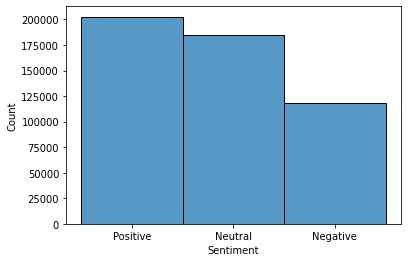

In [10]:
sns.histplot(tweets['Sentiment'])

##### - *Analyzing the wordcloud for Positive and Negative Tweets seperately*

In [11]:
# # Positive Tweets
# all_words = ' '.join([text for text in tweets['Text']]) 

# from wordcloud import WordCloud
# wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(all_words) 
# plt.figure(figsize=(10, 7)) 
# plt.imshow(wordcloud, interpolation="bilinear") 
# plt.axis('off')
# plt.show()
# ## We cant really see the words associated with potive or negatove tweets hence we'll plot them seperately

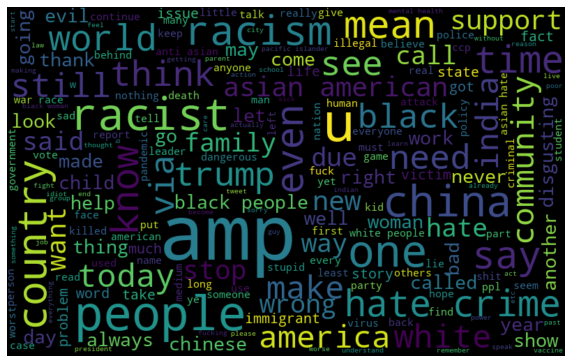

In [12]:
# Negative Tweets
normal_words =' '.join([text for text in tweets['Text'][tweets['Sentiment'] == "Negative"]]) 
wordcloud = WordCloud(width=800, height=500, random_state=21, max_font_size=110).generate(normal_words)
plt.figure(figsize=(10, 7))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

##### - *The above code marks the end of PreProcessing steps*

## Defining and using Training and Test Dataset


##### - *We already have labelled dataset that we'll be using to train our models. The below code gives us a snippet of the data.*

0       0
1       0
2       0
3       1
4       0
       ..
3826    2
3827    2
3828    2
3829    2
3830    2
Name: label, Length: 3831, dtype: int64

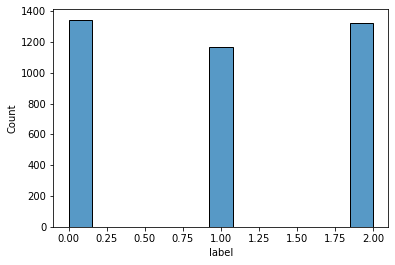

In [19]:
# Additional hate speech data collected from https://github.com/t-davidson/hate-speech-and-offensive-language/blob/master/data/labeled_data.csv

# Changed the file
df=pd.read_csv('/Users/nikhiljoshi/Capstone Project/ML Models/minimum_cleaned_balanced training data.csv')
#df  =   pd.read_csv('C:\\Users\\W0780808\\Downloads\\minimum_cleaned_final_training_data.csv')
#df.head()
sns.histplot(df['label'])


# We will be using 2 approaches for Text Embedding as below:


####    1) BOW
            - ML Models used:
                1.1) Naive Bayes Model
                1.2) KNN Model
                1.3) Decision Tree Model
                1.4) Random Forest Model
                1.5) SVC Model
####    2) TF-IDF
            - ML Models Used
                2.1) Naive Bayes Model
                2.2) KNN Model
                2.3) Decision Tree Model
                2.4) Random Forest Model
                2.5) SVC Model

# Applying ML models using BOW

#### Creating Corpus 1 and using BOW Technique

In [14]:
corpus = [] # Build a new list for all the words from all the reviews

# corpus is a collection of text and a common term used in NLP
for i in range (0, len(df['Text'])):
    review = re.sub('[^a-zA-Z]', ' ', df['Text'][i] )
    review = review.lower()
    review = review.split()
    ps =PorterStemmer()
    review = [ps.stem(word) for word in review if not  word in set(stopwords.words('english'))]
    review = ' '.join(review)
    corpus.append(review)


In [15]:
corpus

['still allow quot ancient chines proverb racist racismisaviru',
 'power chines viru thing realli shown us crazi low iq peopl went sam club costco morn store line wrap around build get insid fuck left disappoint human',
 'cnbc tedro reiter viru could still turn pandem urg fear panic ad greatest enemi right viru fear rumor stigma via',
 'heighten racism experienc asian commun surpris mani peopl belief racial progress widespread american societi covid racismisaviru strongertogeth asianamerican',
 'coronaviru nepali china kp oli direct offici bring back nepali wuhan china keep',
 'iamnotaviru heard use imag articl covid patient outsid china',
 'proven past year hate american america place countri risk busi fake impeach worri chines viru pelosi want tri money',
 'fact coronaviru probabl come us becom world pandem fact legaci media democrat tri blame fact ought preempt china commi nation narrow window make abundantli clear',
 'last fuck time coronaviru excus racist asian',
 'think campaign 

In [21]:
cvec = CountVectorizer()
X = cvec.fit_transform(corpus).todense()
y = df.iloc[:,1].values

### Splitting Data in Test and Training Dataset

In [22]:
X_train, X_test, y_train, y_test = train_test_split(X , y, test_size = 0.20, random_state = 0)

### 1.1) Naive Bayes Model

Accuracy Score Percentage is:: 64.54
              precision    recall  f1-score   support

           0       0.70      0.49      0.57       268
           1       0.65      0.75      0.70       221
           2       0.61      0.72      0.66       278

    accuracy                           0.65       767
   macro avg       0.65      0.65      0.64       767
weighted avg       0.65      0.65      0.64       767



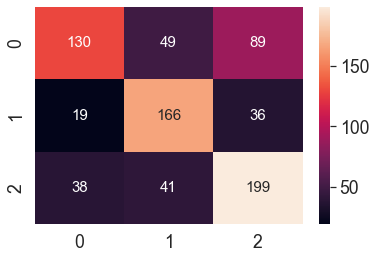

In [23]:
classifierused = GaussianNB() # Defining the classifier used
classifierused.fit(X_train, y_train) # Fitting Classifier to the Training Data Set

# Predicting the results below
y_pred = classifierused.predict(X_test)

# Generating Confusion Matrix
cmatrix = confusion_matrix(y_test, y_pred)

# Generating Accuracy Scores
accuracy = accuracy_score(y_test, y_pred)

#Preparing Confusion Matrix Heatmap
df_for_cm = pd.DataFrame(cmatrix, range(3),range(3))
sns.set(font_scale=1.6)
sns.heatmap(df_for_cm, annot_kws={"size": 15},fmt='g',annot=True)

#Printing results
print("Accuracy Score Percentage is::", round((accuracy)*100,2))

# Printing Classification Report for Precision, recall and F1 Score
print(classification_report(y_test, y_pred))



### 1.2) KNN Model

Accuracy Score Percentage is:: 51.63
              precision    recall  f1-score   support

           0       0.46      0.79      0.58       268
           1       0.89      0.26      0.41       221
           2       0.52      0.46      0.49       278

    accuracy                           0.52       767
   macro avg       0.62      0.50      0.49       767
weighted avg       0.61      0.52      0.50       767



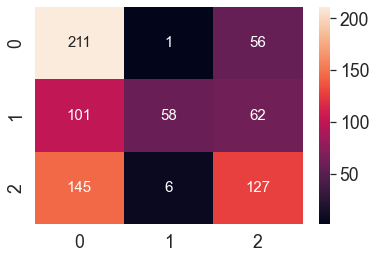

In [24]:

knn = KNeighborsClassifier(n_neighbors=10)  # Defining the classifier used
knn.fit(X_train, y_train) # Fitting Classifier to the Training Data Set

# Predicting the results below 
y_pred=knn.predict(X_test)

# Generating Confusion Matrix
cmatrix = confusion_matrix(y_test, y_pred)

# Generating Accuracy Scores
accuracy = accuracy_score(y_test, y_pred)

df_for_cm = pd.DataFrame(cmatrix, range(3),range(3))
sns.set(font_scale=1.6)
sns.heatmap(df_for_cm, annot_kws={"size": 15},fmt='g',annot=True)

#Printing results
print("Accuracy Score Percentage is::", round((accuracy)*100,2))

# Printing Classification Report for Precision, recall and F1 Score
print(classification_report(y_test, y_pred))


### 1.3) Decision Tree Model

Accuracy Score Percentage is:: 70.01
              precision    recall  f1-score   support

           0       0.63      0.74      0.68       268
           1       0.82      0.77      0.80       221
           2       0.69      0.60      0.64       278

    accuracy                           0.70       767
   macro avg       0.71      0.71      0.71       767
weighted avg       0.71      0.70      0.70       767



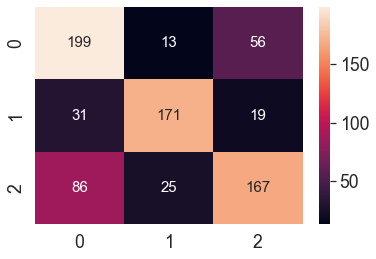

In [25]:

dt_clf = DecisionTreeClassifier(criterion = 'entropy', random_state= 0) # Defining the classifier used
dt_clf.fit(X_train, y_train)  # Fitting Classifier to the Training Data Set

# Predicting the results below
y_pred = dt_clf.predict(X_test)


# Generating Confusion Matrix
cmatrix = confusion_matrix(y_test, y_pred)

# Generating Accuracy Scores
accuracy = accuracy_score(y_test, y_pred)

#Preparing Confusion Matrix Heatmap
df_for_cm = pd.DataFrame(cmatrix, range(3),range(3))
sns.set(font_scale=1.6)
sns.heatmap(df_for_cm, annot_kws={"size": 15},fmt='g',annot=True)

#Printing results
print("Accuracy Score Percentage is::", round((accuracy)*100,2))

# Printing Classification Report for Precision, recall and F1 Score
print(classification_report(y_test, y_pred))


### 1.4) Random Forest Model

Accuracy Score Percentage is:: 74.58
              precision    recall  f1-score   support

           0       0.67      0.77      0.72       268
           1       0.86      0.76      0.81       221
           2       0.74      0.71      0.73       278

    accuracy                           0.75       767
   macro avg       0.76      0.75      0.75       767
weighted avg       0.75      0.75      0.75       767



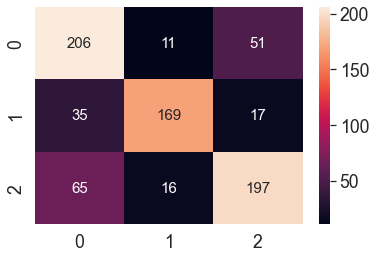

In [26]:
# Fitting classifier to the Training set

# Defining the classifier used
model = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state=0) 

model.fit(X_train, y_train)     # Fitting Classifier to the Training Data Set

# Predicting the results below
y_pred = model.predict(X_test)

# Generating Confusion Matrix
cmatrix = confusion_matrix(y_test, y_pred)

# Generating Accuracy Scores
accuracy = accuracy_score(y_test, y_pred)

#Preparing Confusion Matrix Heatmap
df_for_cm = pd.DataFrame(cmatrix, range(3),range(3))
sns.set(font_scale=1.6)
sns.heatmap(df_for_cm, annot_kws={"size": 15},fmt='g',annot=True)

#Printing results
print("Accuracy Score Percentage is::", round((accuracy)*100,2))

# Printing Classification Report for Precision, recall and F1 Score
print(classification_report(y_test, y_pred))


### 1.5) SVC Model

Accuracy Score Percentage is:: 73.79
              precision    recall  f1-score   support

           0       0.67      0.76      0.71       268
           1       0.86      0.78      0.82       221
           2       0.73      0.69      0.71       278

    accuracy                           0.74       767
   macro avg       0.75      0.74      0.74       767
weighted avg       0.74      0.74      0.74       767



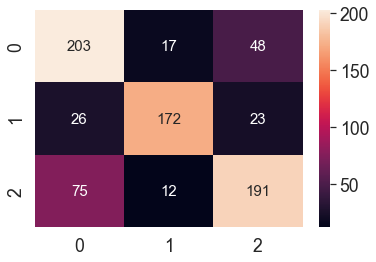

In [27]:
clf = SVC(kernel = 'linear')    # Defining the classifier used

clf.fit(X_train, y_train)      # Fitting Classifier to the Training Data Set

# Predicting the results below
y_pred = clf.predict(X_test)

# Generating Confusion Matrix
cmatrix = confusion_matrix(y_test, y_pred)

# Generating Accuracy Scores
accuracy = accuracy_score(y_test, y_pred)

#Preparing Confusion Matrix Heatmap
df_for_cm = pd.DataFrame(cmatrix, range(3),range(3))
sns.set(font_scale=1.6)
sns.heatmap(df_for_cm, annot_kws={"size": 15},fmt='g',annot=True)

#Printing results
print("Accuracy Score Percentage is::", round((accuracy)*100,2))

# Printing Classification Report for Precision, recall and F1 Score
print(classification_report(y_test, y_pred))


# Applying ML models using TF-IDF

#### Creating Corpus 2 and using TF-IDF Technique

In [28]:
corpus2 = []

for i in range (0, len(df['Text'])):
    review = re.sub('[^a-zA-Z]', ' ', df['Text'][i] )
    review = review.lower()
    review = review.split()
    ps =PorterStemmer()
    review = [ps.stem(word) for word in review if not  word in set(stopwords.words('english'))]
    review = ' '.join(review)
    corpus2.append(review)

In [29]:
vectorizer = TfidfVectorizer (max_features=2500, min_df=7, max_df=0.8, stop_words=stopwords.words('english'))
corpus2 = vectorizer.fit_transform(corpus2).toarray()
X=corpus2

In [32]:
y = df.iloc[:,1].values

### 2.1) Naive Bayes Model

Accuracy Score Percentage is:: 60.37
              precision    recall  f1-score   support

           0       0.62      0.58      0.60       268
           1       0.57      0.77      0.66       221
           2       0.64      0.49      0.56       278

    accuracy                           0.60       767
   macro avg       0.61      0.61      0.60       767
weighted avg       0.61      0.60      0.60       767



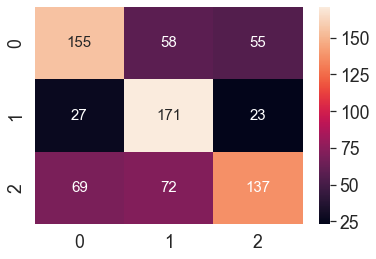

In [33]:
X_train, X_test, y_train, y_test = train_test_split(
    X,y, test_size=0.2,random_state = 0)
classifierused = GaussianNB()   # Defining the classifier used
classifierused.fit(X_train, y_train)     # Fitting Classifier to the Training Data Set

# Predicting the results below
y_pred = classifierused.predict(X_test)

# Generating Confusion Matrix
cmatrix = confusion_matrix(y_test, y_pred)

# Generating Accuracy Scores
accuracy = accuracy_score(y_test, y_pred)

#Preparing Confusion Matrix Heatmap
df_for_cm = pd.DataFrame(cmatrix, range(3),range(3))
sns.set(font_scale=1.6)
sns.heatmap(df_for_cm, annot_kws={"size": 15},fmt='g',annot=True)

#Printing results
print("Accuracy Score Percentage is::", round((accuracy)*100,2))

# Printing Classification Report for Precision, recall and F1 Score
print(classification_report(y_test, y_pred))


### 2.2) KNN Model

Accuracy Score Percentage is:: 70.14
              precision    recall  f1-score   support

           0       0.67      0.69      0.68       268
           1       0.93      0.56      0.70       221
           2       0.64      0.82      0.72       278

    accuracy                           0.70       767
   macro avg       0.75      0.69      0.70       767
weighted avg       0.73      0.70      0.70       767



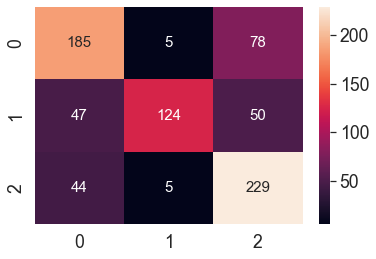

In [34]:
X_train, X_test, y_train, y_test = train_test_split(
    X,y, test_size=0.2,random_state = 0)


knn = KNeighborsClassifier(n_neighbors=30)  # Defining the classifier used
knn.fit(X_train, y_train) # Fitting Classifier to the Training Data Set

# Predicting the results below 
y_pred=knn.predict(X_test)

# Generating Confusion Matrix
cmatrix = confusion_matrix(y_test, y_pred)

# Generating Accuracy Scores
accuracy = accuracy_score(y_test, y_pred)

df_for_cm = pd.DataFrame(cmatrix, range(3),range(3))
sns.set(font_scale=1.6)
sns.heatmap(df_for_cm, annot_kws={"size": 15},fmt='g',annot=True)

#Printing results
print("Accuracy Score Percentage is::", round((accuracy)*100,2))

# Printing Classification Report for Precision, recall and F1 Score
print(classification_report(y_test, y_pred))


### 2.3) Decision Tree Model

Accuracy Score Percentage is:: 72.36
              precision    recall  f1-score   support

           0       0.69      0.72      0.70       268
           1       0.79      0.82      0.80       221
           2       0.70      0.65      0.68       278

    accuracy                           0.72       767
   macro avg       0.73      0.73      0.73       767
weighted avg       0.72      0.72      0.72       767



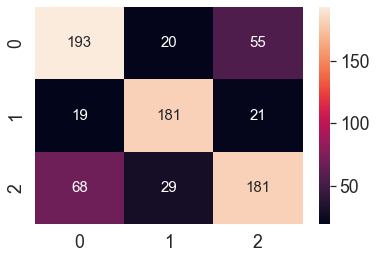

In [35]:
X_train, X_test, y_train, y_test = train_test_split(
    X,y, test_size=0.2,random_state = 0)

dt_clf = DecisionTreeClassifier(criterion = 'entropy', random_state= 0) # Defining the classifier used
dt_clf.fit(X_train, y_train)  # Fitting Classifier to the Training Data Set

# Predicting the results below
y_pred = dt_clf.predict(X_test)


# Generating Confusion Matrix
cmatrix = confusion_matrix(y_test, y_pred)

# Generating Accuracy Scores
accuracy = accuracy_score(y_test, y_pred)

#Preparing Confusion Matrix Heatmap
df_for_cm = pd.DataFrame(cmatrix, range(3),range(3))
sns.set(font_scale=1.6)
sns.heatmap(df_for_cm, annot_kws={"size": 15},fmt='g',annot=True)

#Printing results
print("Accuracy Score Percentage is::", round((accuracy)*100,2))

# Printing Classification Report for Precision, recall and F1 Score
print(classification_report(y_test, y_pred))


### 2.4) Random Forest Model

Accuracy Score Percentage is:: 74.19
              precision    recall  f1-score   support

           0       0.67      0.78      0.72       268
           1       0.82      0.81      0.81       221
           2       0.77      0.65      0.70       278

    accuracy                           0.74       767
   macro avg       0.75      0.75      0.75       767
weighted avg       0.75      0.74      0.74       767



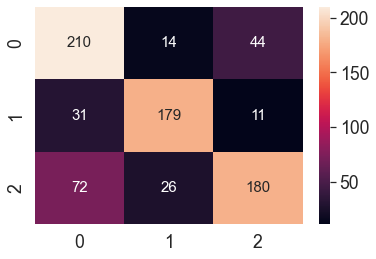

In [36]:
X_train, X_test, y_train, y_test = train_test_split(
    X,y, test_size=0.2,random_state = 0)
# Defining the classifier used
model = RandomForestClassifier(n_estimators = 10, criterion = 'entropy', random_state=0) 

model.fit(X_train, y_train)     # Fitting Classifier to the Training Data Set

# Predicting the results below
y_pred = model.predict(X_test)

# Generating Confusion Matrix
cmatrix = confusion_matrix(y_test, y_pred)

# Generating Accuracy Scores
accuracy = accuracy_score(y_test, y_pred)

#Preparing Confusion Matrix Heatmap
df_for_cm = pd.DataFrame(cmatrix, range(3),range(3))
sns.set(font_scale=1.6)
sns.heatmap(df_for_cm, annot_kws={"size": 15},fmt='g',annot=True)

#Printing results
print("Accuracy Score Percentage is::", round((accuracy)*100,2))

# Printing Classification Report for Precision, recall and F1 Score
print(classification_report(y_test, y_pred))


### 2.5) SVC Model

Accuracy Score Percentage is:: 76.27
              precision    recall  f1-score   support

           0       0.70      0.79      0.74       268
           1       0.86      0.77      0.82       221
           2       0.76      0.73      0.74       278

    accuracy                           0.76       767
   macro avg       0.77      0.76      0.77       767
weighted avg       0.77      0.76      0.76       767



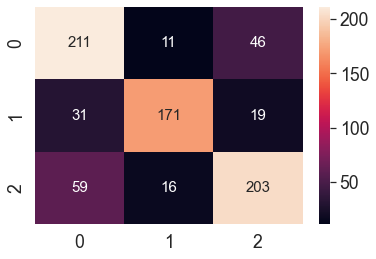

In [37]:
X_train, X_test, y_train, y_test = train_test_split(
    X,y, test_size=0.2,random_state = 0)

clf = SVC(kernel = 'linear')    # Defining the classifier used

clf.fit(X_train, y_train)      # Fitting Classifier to the Training Data Set

# Predicting the results below
y_pred = clf.predict(X_test)

# Generating Confusion Matrix
cmatrix = confusion_matrix(y_test, y_pred)

# Generating Accuracy Scores
accuracy = accuracy_score(y_test, y_pred)

#Preparing Confusion Matrix Heatmap
df_for_cm = pd.DataFrame(cmatrix, range(3),range(3))
sns.set(font_scale=1.6)
sns.heatmap(df_for_cm, annot_kws={"size": 15},fmt='g',annot=True)

#Printing results
print("Accuracy Score Percentage is::", round((accuracy)*100,2))

# Printing Classification Report for Precision, recall and F1 Score
print(classification_report(y_test, y_pred))

# Final Outcome

#### F1 Score Comparison

| Model Name | Bag of Words | TF-IDF |
| :- | :- | :- |  
|  Naive Bayes  |  xx    | xx  | 
|  KNN  |  xx   | xx  | 
|  Decision Tree |  xx   | xx  | 
|  Random Forest |  xx   | xx  | 
|  SVM |  xx   | xx  | 